# Is Fandango Still Inflating Ratings?

In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest ([Fandango](https://www.fandango.com/) is an online movie ratings aggregator). He published his analysis [in this article](https://fivethirtyeight.com/features/fandango-movies-ratings/) — a great piece of data journalism that's totally worth reading.

Fandango displays a 5-star rating system on their website, where the minimum rating is 0 stars and the maximum is 5 stars.

Hickey found that there's a significant discrepancy between the number of stars displayed to users and the actual rating, which he was able to find in the HTML of the page. He was able to find that:

* The actual rating was almost always rounded **up** to the nearest half-star. For instance, a 4.1 movie would be rounded off to 4.5 stars, not to 4 stars, as you may expect.
* In the case of 8% of the ratings analyzed, the rounding up was done to the nearest whole star. For instance, a 4.5 rating would be rounded off to 5 stars.
* For one movie rating, the rounding off was completely bizarre: from a rating of 4 in the HTML of the page to a displayed rating of 5 stars.

![](https://s3.amazonaws.com/dq-content/288/s1gp_actual_vs_displayed.png)
<center>Source: [FiveThirtyEight](https://fivethirtyeight.com/features/fandango-movies-ratings/)</center>

The two distributions above are displayed using a simple line plot, which is also a valid way to show the shape of a distribution. The variable being examined is movie rating, and for each unique rating we can see its relative frequency (percentage) on the y-axis of the graph. When an analysis report is intended for large audiences, relative frequencies (especially percentages) are preferred over absolute frequencies.

Both distributions above are strongly left skewed, suggesting that movie ratings on Fandango are generally high or very high. We can see there's no rating under 2 stars in the sample Hickey analyzed. The distribution of displayed ratings is clearly shifted to the right compared to the actual rating distribution, suggesting strongly that Fandango inflates the ratings under the hood.

Fandango's officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible. Presumably, this has already happened, although we can't tell for sure since the actual rating value doesn't seem to be displayed anymore in the pages' HTML.

In this project, we'll analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

## Getting Familiar With The Data

In [1]:
import pandas as pd
pd.options.display.max_columns = 100  # Avoid having displayed truncated output

before = pd.read_csv('fandango_score_comparison.csv')
after = pd.read_csv('movie_ratings_16_17.csv')

before.head(3)

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,Metacritic_norm,Metacritic_user_nom,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,3.30,3.55,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,3.35,3.75,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,3.20,4.05,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5


In [2]:
after.head(3)

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.5,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.5,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.0,2.35,2.5,3.5,2.0,2.5


Let's isolate the columns in a separate variables. Below are the columns that we are interested in.

In [3]:
fb = before[['FILM', 
             'Fandango_Stars', 
             'Fandango_Ratingvalue', 
             'Fandango_votes', 
             'Fandango_Difference'
            ]]

fa = after[['movie', 
            'year', 
            'fandango'
           ]]

fb.head(3)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5


In [4]:
fa.head(3)

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0


## Defining the population

The population of interest for our analysis is made of all the movie ratings stored on Fandango's website, regardless of the releasing year.

Because we want to find out whether the parameters of this population changed after Hickey's analysis, we're interested in sampling the population at two different periods in time — before and after Hickey's analysis — so we can compare the two states.

The data of two states — before and after — are samples of our interest point. Now we need to figure out if they are both representative to the population, meaning low sampling error.

From Hickey's article and from the `README.md` of [the data set's repository](https://github.com/fivethirtyeight/data/tree/master/fandango), we can see that he used the following sampling criteria:

* The movie must have had at least 30 fan ratings on Fandango's website at the time of sampling (Aug. 24, 2015).
* The movie must have had tickets on sale in 2015.

This is not considered as random sampling, because not every movie had the same chance to be included in the sample — some movies didn't have a chance at all (like those having under 30 fan ratings or those without tickets on sale in 2015). It's questionable whether this sample is representative of the entire population we're interested to describe. It seems more likely that it isn't, mostly because this sample is subject to temporal trends — e.g. movies in 2015 might have been outstandingly good or bad compared to other years.

The sampling conditions for our other sample were (as it can be read in the README.md of the data set's repository):

* The movie must have been released in 2016 or later.
* The movie must have had a considerable number of votes and reviews (unclear how many from the README.md or from the data).

This second sample is also subject to temporal trends and it's unlikely to be representative of our population of interest.

Both these authors had certain research questions in mind when they sampled the data, and they used a set of criteria to get a sample that would fit their questions. Their sampling method is called purposive sampling (or judgmental/selective/subjective sampling). While these samples were good enough for their research, they don't seem too useful for us.

Therefore,

## We Should Slightly Change Our Goal

such that:

* The population of interest changes and the samples we currently work with become representative.
* The new goal is still a fairly good proxy for our initial goal, which was to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

Hence, our new goal: **to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016**

With our new goal, out two data become the population of interest:

1. All Fandango's ratings for popular movies released in 2015
2. All Fandango's ratings for popular movies released in 2016

Here, we define the term `popular` to be <u>only if a movie has 30 fan ratings or more on Fandango</u>.



In [5]:
fa.sample(10, random_state = 5)

,movie,year,fandango
21,Before the Flood,2016,3.5
54,Fifty Shades of Black,2016,2.5
84,Jason Bourne,2016,4.0
102,Manchester by the Sea,2016,3.5
26,Blood Father,2016,4.0
202,Under the Shadow,2016,4.0
208,Why Him?,2016,4.0
28,Busanhaeng,2016,4.5
6,A Street Cat Named Bob,2016,4.5
161,The Autopsy of Jane Doe,2016,4.5


As of April 2019, here's what we found from the Fandango website:

| Movie                   | Fan ratings |
|-------------------------|-------------|
| Before the Flood        | 7           |
| Fifty Shades of Black   | 1500        |
| Jason Bourne            | 16315       |
| Manchester by the Sea   | 3490        |
| Blood Father            | 46          |
| Under the Shadow        | 8           |
| Why Him?                | 2739        |
| Busanhaeng              | 277         |
| A Street Cat Named Bob  | 40          |
| The Autopsy of Jane Doe | 41          |

At least 8/10 samples have more than 30 fan ratings, which is good enough.

According to the documentation, the dataset only contains movies with at least 30 fan ratings. Let's confirm that!

In [6]:
sum(fb['Fandango_votes'] < 30)

0

Now we have confirmed our assumption is correct.
Next, since we do not have a specific column for `Year`, let's extract it from the `FILM` column.

In [7]:
# pd.options.mode.chained_assignment = None
fb['Year'] = fb['FILM'].str[-5:-1]
fb.head(2)

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,Year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015


Let's check out the frequency distribution for the Year column:

In [8]:
fb['Year'].value_counts()

2015    129
2014     17
Name: Year, dtype: int64

Since there are movies not released in 2015, we make a deep copy of the data before the investigation for year 2015.

In [9]:
fandango_2015 = fb[fb['Year'] == '2015'].copy()
fandango_2015['Year'].value_counts()

2015    129
Name: Year, dtype: int64

Now we examine the data after the investigation, and we make a deep copy as well for year 2016:

In [10]:
fa['year'].value_counts()

2016    191
2017     23
Name: year, dtype: int64

Similarly, there are movies not released in 2016, we make a deep copy of the data before the investigation for year 2016.

In [11]:
fandango_2016 = fa[fa['year'] == 2016].copy()
fandango_2016['year'].value_counts()

2016    191
Name: year, dtype: int64

## Comparing Distribution for Year 2015 and 2016

We can now start analyzing the two samples we isolated before. Once again, our goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016.

First, we generate two kernel density plots on the same figure for the distribution of movie ratings of each sample

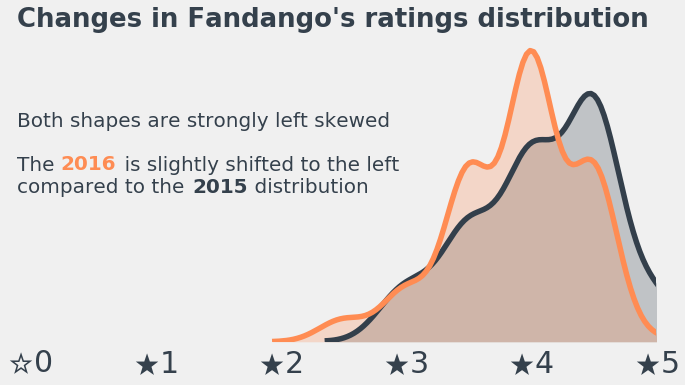

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import arange
%matplotlib inline
plt.style.use('fivethirtyeight')
# sns.set(style='white')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 5.5})

scheme_A = { 
    'red': "#ca0e69",
    'green': "#009a6b",
    'purple': "#8960b3",
    'orange': "#ff8c53",
    'lime': "#909e3f",
    'dark': '#333F4B'
}

# Modify only pos_point1 to change bullet points location
pos_point1=(-0.1, 0.65)
pos_title=(pos_point1[0], 0.95)
bp_fsize=20
title_font=26
color_2016=scheme_A['orange']
color_2015=scheme_A['dark']
color_label=scheme_A['dark']

pos_point2=(pos_point1[0], pos_point1[1]-0.2)
pos_2016=(pos_point2[0]+0.34, pos_point2[1]+0.07) #0.4
pos_2015=(pos_point2[0]+1.4, pos_point2[1]) #1.55

min_rating=0
max_rating=5
tick_interval=1.0
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(fandango_2015['Fandango_Stars'], shade=True, color=color_2015)
sns.kdeplot(fandango_2016['fandango'], shade=True, color=color_2016)

title_text='Changes in Fandango\'s ratings distribution'
pads=' '*11
bp1_text='Both shapes are strongly left skewed'
bp2_text='The'+pads+'is slightly shifted to the left\ncompared to the'+pads+'distribution'

sns.despine(ax=ax,left=True, bottom=True, top=True, right=True)
plt.text(pos_title[0],pos_title[1], title_text, fontsize=title_font, fontweight='semibold', color=color_label)
plt.text(pos_2015[0], pos_2015[1], '2015', fontsize=bp_fsize, fontweight='bold', color=color_2015)
plt.text(pos_2016[0], pos_2016[1], '2016', fontsize=bp_fsize, fontweight='bold', color=color_2016)
plt.text(pos_point1[0], pos_point1[1], bp1_text, fontsize=bp_fsize, fontweight='ultralight', color=color_label)
plt.text(pos_point2[0], pos_point2[1], bp2_text, fontsize=bp_fsize, fontweight='ultralight', color=color_label)
plt.xlim(min_rating, max_rating)

plt.xticks(arange(min_rating, max_rating+0.1, tick_interval))
wstar='$\u2606$'
bstar='$\u2605$'
ratings=[wstar+'0',bstar+'1',bstar+'2',bstar+'3',bstar+'4',bstar+'5']

plt.xticks(arange(6), ratings, color=color_label,fontsize='30')

plt.yticks([])
ax.get_legend().remove()
ax.grid(False)
plt.show()

The left skew suggests that in 2016 the ratings are slightly lower than 2015, which indicated changes after investigation.

## Examining the Frequency Distribution

So far so good, but we need to analyze more granular information. Let's examine the frequency tables of the two distributions to analyze some numbers. Because the data sets have different numbers of movies, we normalize the tables and show percentages instead.

In [13]:
f2015_norm = (fandango_2015['Fandango_Stars']
                 .value_counts(normalize = True)
                 .sort_index() * 100)
f2016_norm = (fandango_2016['fandango']
                 .value_counts(normalize = True)
                 .sort_index() * 100)
(pd.concat([f2015_norm, f2016_norm], axis=1)
    .rename(index=str, columns={"Fandango_Stars": "2015", "fandango": "2016"})
)

,2015,2016
2.5,NaN,3.141361
3.0,8.527132,7.329843
3.5,17.829457,24.083770
4.0,28.682171,40.314136
4.5,37.984496,24.607330
5.0,6.976744,0.523560


In 2016, very high ratings (4.5 and 5 stars) had significantly lower percentages compared to 2015. In 2016, under 1% of the movies had a perfect rating of 5 stars, compared to 2015 when the percentage was close to 7%. Ratings of 4.5 were also more popular in 2015 — there were approximately 13% more movies rated with a 4.5 in 2015 compared to 2016.

The minimum rating is also lower in 2016 — 2.5 instead of 3 stars, the minimum of 2015. There clearly is a difference between the two frequency distributions.

For some other ratings, the percentage went up in 2016. There was a greater percentage of movies in 2016 that received 3.5 and 4 stars, compared to 2015. 3.5 and 4.0 are high ratings and this challenges the direction of the change we saw on the kernel density plots.

## Determining the Direction of the Change

Let's compute the mean, median, and mode for each distribution and visualize them using a slopegraph to emphasize the changes from 2015 to 2016!

In [14]:
mean_2015 = fandango_2015['Fandango_Stars'].mean()
mean_2016 = fandango_2016['fandango'].mean()

median_2015 = fandango_2015['Fandango_Stars'].median()
median_2016 = fandango_2016['fandango'].median()

mode_2015 = fandango_2015['Fandango_Stars'].mode()[0] # the output of Series.mode() is a bit uncommon
mode_2016 = fandango_2016['fandango'].mode()[0]

summary = pd.DataFrame()
summary['year'] = ['2015','2016'] * 3
summary['index'] = ['mean'] * 2 + ['median'] * 2 + ['mode'] * 2
summary['stars'] = [mean_2015, mean_2016, median_2015, median_2016, mode_2015, mode_2016]
summary

,year,index,stars
0,2015,mean,4.085271
1,2016,mean,3.887435
2,2015,median,4.000000
3,2016,median,4.000000
4,2015,mode,4.500000
5,2016,mode,4.000000


/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


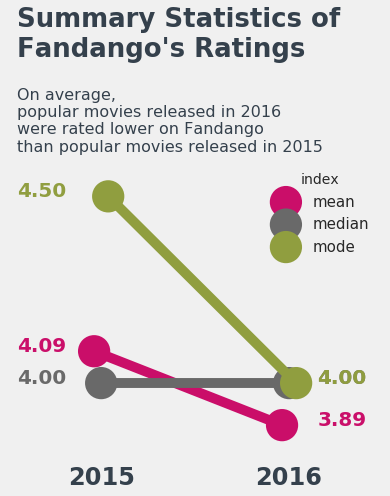

In [15]:
title_text='Summary Statistics of\nFandango\'s Ratings'
hl_text='''On average,
popular movies released in 2016
were rated lower on Fandango
than popular movies released in 2015
'''

pos_label_left=-0.45
pos_label_right=1.15
palette=(scheme_A['red'],
         'dimgrey',
         scheme_A['lime'])

fig2, ax2 = plt.subplots(figsize=(6, 5))
plt.text(pos_label_left,
         4.875, 
         title_text, 
         fontsize=title_font, 
         fontweight='semibold', 
         color=color_label)

for i in range(0,6,2):
    l=summary.loc[i,'stars']
    r=summary.loc[i+1,'stars']
    c=palette[int(i/2)]
    plt.text(pos_label_left,
             l, 
             "{0:.2f}".format(round(l,2)), 
             fontsize=bp_fsize, 
             fontweight='semibold', 
             color=c)
    plt.text(pos_label_right,
             r, 
             "{0:.2f}".format(round(r,2)), 
             fontsize=bp_fsize, 
             fontweight='semibold', 
             color=c)

sns.pointplot(x='year', 
              y="stars", 
              hue='index', 
              data=summary, 
              palette=palette,
              dodge=True
             )

plt.text(pos_label_left,
         4.575, 
         hl_text, 
         fontsize=16, 
         fontweight='light', 
         color=color_label)

plt.yticks([])
plt.xticks(color=color_label,fontsize='24',fontweight='black')
ax2.set_ylabel('')
ax2.set_xlabel('')
# ax2.get_legend().remove()
plt.show()

# Conclusion

Our slopegraph showed that there is a slight decrease in 2016 ratings compared to 2015 ratings for popular movies. It is likely that the decreased was caused by Fandango fixing the biased rating system after Hickey's analysis.